<a href="https://colab.research.google.com/github/pachterlab/FGP_2023/blob/main/loci_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Analysis of ATAC-seq Data
We show how ATAC peak site means vary across sites within each locus, supporting the decision to include a non-homogenous 'field strength' in our Ising-like chromatin model. We also calculate correlations between each pair of neighboring sites at each locus, justifying the inclusion of nearest neighbor interactions in our chromatin model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define functions to decompose a multi-site locus into pairs and calculate Pearson correlations between the two sites in each pair.

In [ ]:
def pair_from_config(config, index):
    '''
    Extract ith pair from list of openness values in a chromatin configuration.
    '''
    return (config[index], config[index+1])


def find_probs(pairs):
    '''
    Find proportions of each possible combination of site-openness values from a list of pair site values.

    Args:
        pairs (list of tuples): List of pairs of site-openness values, e.g. [(0,0), (1,0), (0,0)]

    Output:
        proportion of pairs with each of the four possible combinations:
            p00 = fraction of pairs with value (0,0)
    '''

    p00, p01, p10, p11 = pairs.count((0,0)), pairs.count((0,1)), pairs.count((1,0)), pairs.count((1,1))
    tot = len(pairs)
    p00, p01, p10, p11 = p00/tot, p01/tot, p10/tot, p11/tot

    return(p00, p01, p10, p11)

def Pearson_corr(p00, p01, p10, p11):
    '''
    Find autocorrelation, given proportions of each pair.

    Args:
        pij (float): propotion of pairs with site-openness value (i, j), where i, j take values 0,1
        n (int): number of pairs

    Output:
        autocorrelation of the data given these proportions
        N.B. We use sample covariance and sample variances.
        Sample covariance = p11 - (p01 + p11)(p10 + p11) = p11*p00 - p01*p10 (use all sum to 1).
    '''

    sigma1 = ((p11 + p10) - (p11 + p10)**2)**(1/2)
    sigma2 = ((p11 + p01) - (p11 + p01)**2)**(1/2)
    mu1, mu2 = p11 + p10, p11 + p01

    # If either site is closed (or open) in all cells, we cannot calculate a correlation.
    if sigma1==0 or sigma2==0:
      return False, False

    corr = (p11*p00 - p01*p10)/sigma1/sigma2
    av_mean = (mu1 + mu2)/2

    return corr, av_mean

## Import one of the pre-processed datasets, specified by user.



In the cell below, specify the dataset by setting the variable: 'dataset'.

In [ ]:
## Set dataset to the desired value to control which data is imported.
# Choose 'PBMCs', 'mouse_cortex' or 'human_mouse'
dataset = 'PBMCs'

transcript_files = {'human_mouse': 'human_mouse_mixture/transcripts_hum_mouse_mixture.txt',
                    'mouse_cortex': 'mouse_cortex/transcripts.txt', 'PBMCs': 'PBMCs/transcripts.txt' }
data_files = {'human_mouse': {'mouse':'human_mouse_mixture/mixed_mouse_dist_dict.pkl', 'human':'human_mouse_mixture/mixed_human_dist_dict.pkl'},
              'mouse_cortex': 'mouse_cortex/mouse_cortex_dist_dict.pkl', 'PBMCs': 'PBMCs/dist_dict.pkl'}
file_location = '/content/drive/MyDrive/Colab Notebooks/FGP_2023/'

## Import chromosomal location information.
transcript_file = file_location + transcript_files[dataset]
df_transcripts = pd.read_csv (transcript_file, '\t', skiprows=0, skipinitialspace=True, header=None)
df_transcripts.columns = ['location']
df_transcripts.index.name = 'transcript'
df_transcripts.index = df_transcripts.index+1

The human-mouse mixture dataset requires additional sorting into mouse and human genetic locations.

In [ ]:
## Sort loci into human and mouse genomes.
if dataset == 'human_mouse':

  with open(file_location + data_files[dataset]['mouse'], 'rb') as fp:
    mouse_dist_dict = pickle.load(fp)

  with open(file_location + data_files[dataset]['human'], 'rb') as fp:
    human_dist_dict = pickle.load(fp)

  human_loci, mouse_loci = [], []
  for key in human_dist_dict.keys():
      loc_string = df_transcripts.loc[key[0]]['location'].split('-')[0]+ '-' + df_transcripts.loc[key[-1]]['location'].split('-')[1]
      if loc_string.startswith('h'):
          human_loci += [key]
      elif loc_string.startswith('m'):
          mouse_loci += [key]
      else:
          print('Genomic location not recognized.')

  loci_keys = human_loci + mouse_loci
  loci_dists = {}
  for key in human_loci:
    loci_dists[key] = human_dist_dict[key]
  for key in mouse_loci:
    loci_dists[key] = mouse_dist_dict[key]

else:

  dist_file = file_location + data_files[dataset]
  with open(dist_file, 'rb') as fp:
    loci_dists = pickle.load(fp)
  loci_keys = [i for i in loci_dists.keys()]

## Calculate correlations between neighbors in each adjacent pair of ATAC peaks in each locus.

We calculate means and variances separately for each site, to then find the Pearson correlation coefficient between each adjacent pair of sites.

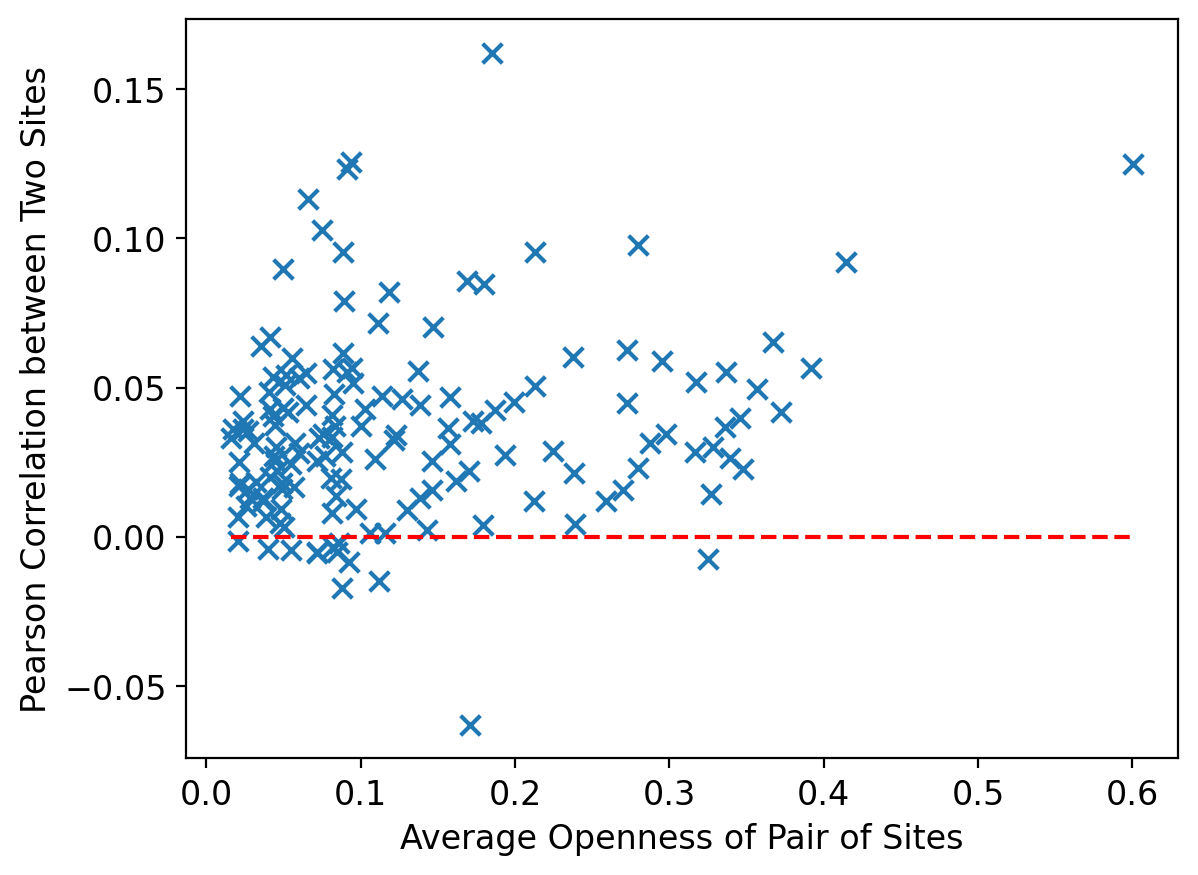

In [ ]:
# Get autocorrelations at each locus pair.
N = 6
corrs, av_means = [], []

for loc, dist in loci_dists.items():

    # Find openness values for each pair across all cells.
    for i in range(N-1):

        pairs = []

        for config, frequency in dist.items():

            pair = pair_from_config(config, i)
            pairs += [pair]*frequency

        p00, p01, p10, p11 = find_probs(pairs)
        corr, av_mean = Pearson_corr(p00, p01, p10, p11)
        corrs += [corr]
        av_means += [av_mean]

## Plot Pearson correlations against average site means per pair.
mean_range = np.linspace(min(av_means), max(av_means), 100)
plt.scatter(av_means, corrs, marker='x', s=50)
plt.plot(mean_range, [0]*len(mean_range), color='red', linestyle='--')
plt.xlabel('Average Openness of Pair of Sites', fontsize=12)
plt.ylabel('Pearson Correlation between Two Sites', fontsize=12)
plt.title('Pearson Correlations: ' + dataset)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('Pearson_corrs_' + dataset + '.png')
plt.show()

## Plot the average openness at each site within the locus for all loci in the dataset.

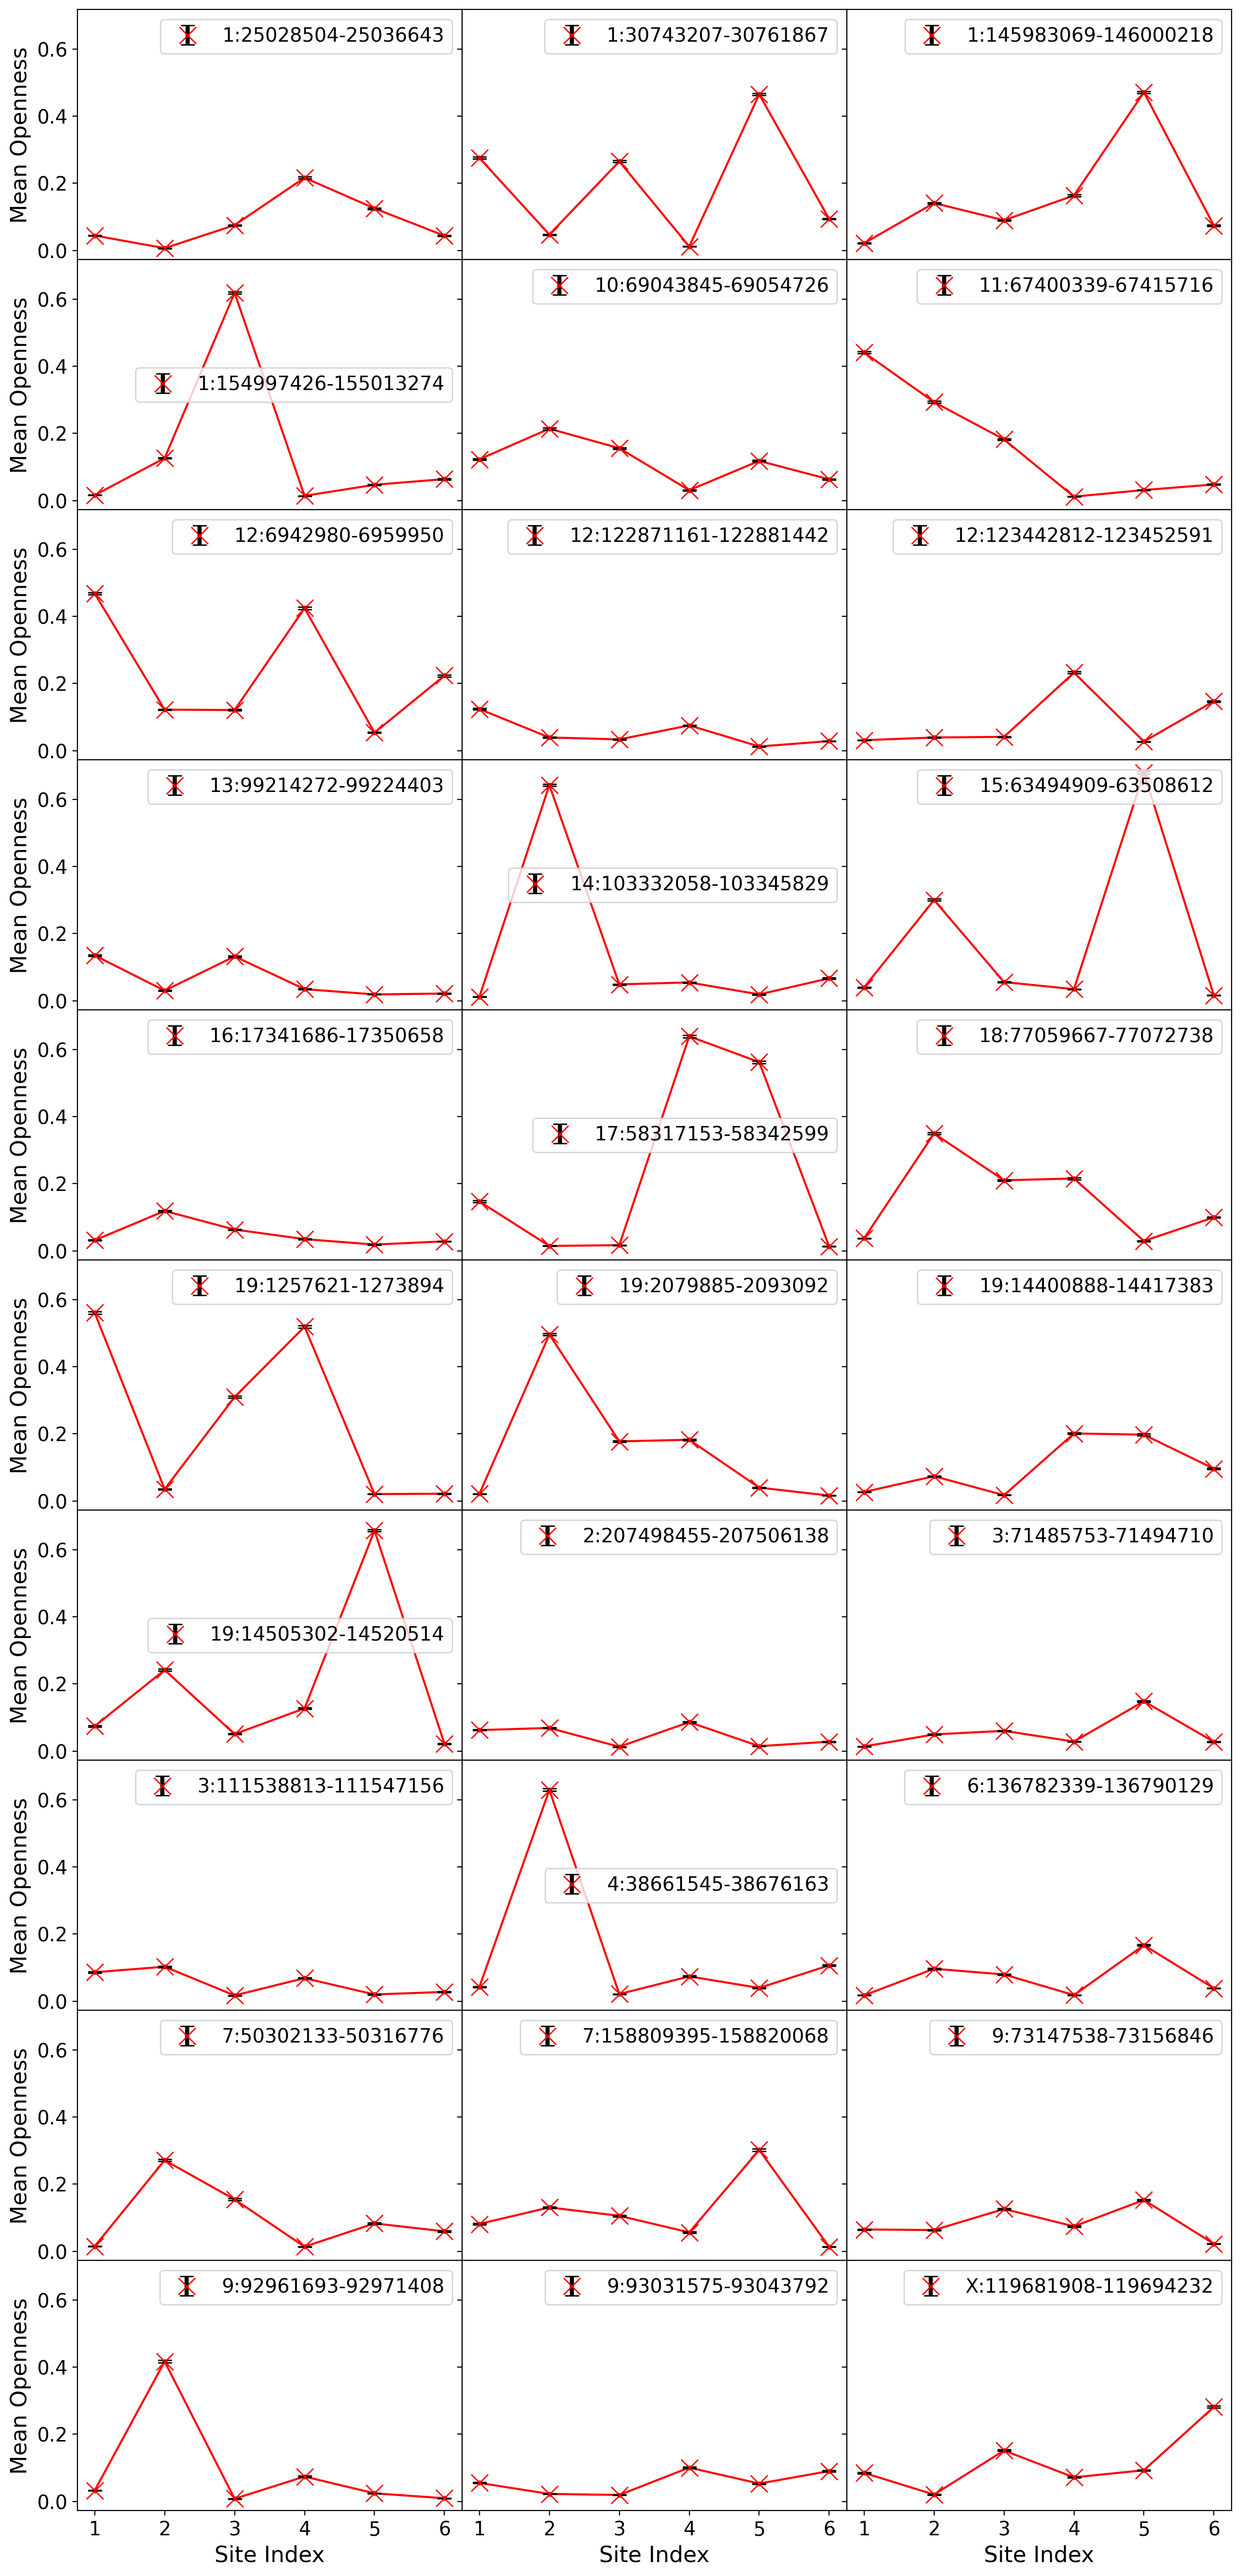

In [ ]:
## Each dataset has a different number of suitable ATAC peak loci.
num_loci_datasets = {'human_mouse':14, 'mouse_cortex': 7, 'PBMCs': 30}
num_loci =  num_loci_datasets[dataset]

## Calculate site means at each locus.
all_means_info = {}
for j in range(num_loci):

    k = list(loci_dists.keys())[j]
    my_locus = loci_dists[k]

    location_start = df_transcripts.loc[k[0]]['location']
    location_end = df_transcripts.loc[k[-1]]['location']
    location_string = location_start.split('-')[0] + '-' + location_end.split('-')[1]

    means = []
    sample_tops = []
    sample_bottoms = []

    for i in range(N):

        # For each site, find mean openness value over all cells.
        openness_values = []
        for configuration in my_locus.keys():
            openness_values +=[list(configuration)[i]]*my_locus[configuration]
        means += [np.mean(openness_values)]

        # Sample the openness values for the site with replacement, niter times, and find the quartiles of the resulting means.
        sample_means = []
        niter = 1000
        for q in range(niter):
            sample_sites = np.random.choice(openness_values,size=len(openness_values), replace=True)
            sample_means += [np.mean(sample_sites)]
        sample_tops += [np.quantile(sample_means, 0.75)]
        sample_bottoms += [np.quantile(sample_means, 0.25)]

    ## Save means and quartiles for a locus.
    ytop = [i-j for i, j in zip(sample_tops, means)]
    ybot = [i-j for i, j in zip(means, sample_bottoms)]
    all_means_info[location_string] = (means, ybot, ytop)

## Set up plots.
names_datasets = {'human_mouse': 'Human-Mouse Mixture', 'mouse_cortex': 'Mouse Cortex', 'PBMCs': 'PBMCs'}
plot_name = 'Mean Site Openness at each Locus: ' + names_datasets[dataset]
size_plots_datasets = {'human_mouse': (5, 3), 'mouse_cortex': (3,3), 'PBMCs': (10,3)}
size_plots =  size_plots_datasets[dataset]

fig = plt.figure(figsize=(5*size_plots[1],size_plots[0]*3))
gs = fig.add_gridspec(size_plots[0], size_plots[1], hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
plt.subplots_adjust(top=0.95)

## Plot means and quartiles at each locus.
for j, (location_string, locus_info) in enumerate(all_means_info.items()):

    means, ybot, ytop = all_means_info[location_string]

    row  = int(np.floor(j/size_plots[1]))
    col = int(j%size_plots[1])
    axs[row][col].plot([i+1 for i in range(N)], means, color='red')
    axs[row][col].scatter([i+1 for i in range(N)], means, s=7, color='red')
    axs[row][col].errorbar([i+1 for i in range(N)], means, yerr=(ybot, ytop), fmt='x', label=location_string, capsize=5, linewidth=3, ecolor='black', mfc='red', ms=12, mec='red')
    axes_label_size, tick_label_size, legend_size = 16, 14, 14
    axs[row][col].set_ylabel('Mean Openness', fontdict={'fontsize': axes_label_size})
    axs[row][col].set_xlabel('Site Index', fontdict={'fontsize': axes_label_size})
    axs[row][col].tick_params(axis='x', labelsize=tick_label_size)
    axs[row][col].tick_params(axis='y', labelsize=tick_label_size)
    axs[row][col].legend(fontsize=legend_size)
    axs[row][col].label_outer()

# Adjust x tick label size for entire bottom row of subplots.
for ax in axs[-1]:
    ax.tick_params(axis='x', labelsize=tick_label_size)
    ax.set_xlabel('Site Index', fontsize=axes_label_size)

plt.savefig(plot_name.replace(' ', '_').lower()+'.png')
plt.show()